# 双边滤波（Bilateral Filter）

In [71]:
import numpy as np
import cupy as cp
import cv2
import string
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [72]:
def load_kernel(src,kname):
    _ = cp.zeros((1,)) # 初始化cuda context
    kernel = cp.core.core.compile_with_cache(src).get_function(kname)
    return kernel

In [73]:
sources = string.Template("""
extern "C"{
 __device__ const int FILTER_SIZE = 9;
__device__ const int FILTER_HALFSIZE = FILTER_SIZE >> 1;
__device__ const int BLOCKDIM = 32;
__device__ const int sigma1 = 50;
__device__ const int sigma2 = 50;
__device__ int index_median(int x, int y, int width) 
{
    return (y * width) + x;
}

__device__ int clamp_median(int value, int bound) 
{
    if (value < 0) {
        return 0;
    }
    if (value < bound) {
        return value;
    }
    return bound - 1;
}

__device__ float exp_f(int i) { return exp((float) i); }


__global__ void bilateral_filter_sm(unsigned char* input, unsigned char* output, int width, int height)
{
    __shared__ float sharedPixels[BLOCKDIM + FILTER_SIZE][BLOCKDIM + FILTER_SIZE];

    const int x = blockIdx.x * blockDim.x + threadIdx.x;
    const int y = blockIdx.y * blockDim.y + threadIdx.y;

    int xBlockLimit_max = blockDim.x - FILTER_HALFSIZE - 1;
    int yBlockLimit_max = blockDim.y - FILTER_HALFSIZE - 1;
    int xBlockLimit_min = FILTER_HALFSIZE;
    int yBlockLimit_min = FILTER_HALFSIZE;

    if (threadIdx.x > xBlockLimit_max && threadIdx.y > yBlockLimit_max) {
    int i = index_median(clamp_median(x + FILTER_HALFSIZE,width), clamp_median(y + FILTER_HALFSIZE,height), width);
            float pixel = input[i];
        sharedPixels[threadIdx.x + 2*FILTER_HALFSIZE][threadIdx.y + 2*FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.x > xBlockLimit_max && threadIdx.y < yBlockLimit_min) {
        int i = index_median(clamp_median(x + FILTER_HALFSIZE,width), clamp_median(y - FILTER_HALFSIZE,height), width);
        float pixel = input[i];
        sharedPixels[threadIdx.x + 2*FILTER_HALFSIZE][threadIdx.y] = pixel;
    }
    if (threadIdx.x < xBlockLimit_min && threadIdx.y > yBlockLimit_max) {
        int i = index_median(clamp_median(x - FILTER_HALFSIZE,width), clamp_median(y + FILTER_HALFSIZE,height), width);
        float pixel = input[i];
        sharedPixels[threadIdx.x][threadIdx.y + 2*FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.x < xBlockLimit_min && threadIdx.y < yBlockLimit_min) {
        int i = index_median(clamp_median(x - FILTER_HALFSIZE,width), clamp_median(y - FILTER_HALFSIZE,height), width);
        float pixel = input[i];
        sharedPixels[threadIdx.x][threadIdx.y] = pixel;
    }
    if (threadIdx.x < xBlockLimit_min) {
        int i = index_median(clamp_median(x - FILTER_HALFSIZE,width), clamp_median(y,height), width);
        float pixel = input[i];
        sharedPixels[threadIdx.x][threadIdx.y + FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.x > xBlockLimit_max) {
        int i = index_median(clamp_median(x + FILTER_HALFSIZE,width), clamp_median(y,height), width);
        unsigned int pixel = input[i];
        sharedPixels[threadIdx.x + 2*FILTER_HALFSIZE][threadIdx.y + FILTER_HALFSIZE] = pixel;
    }
    if (threadIdx.y < yBlockLimit_min) {
        int i = index_median(clamp_median(x,width), clamp_median(y - FILTER_HALFSIZE,height), width);
        float pixel = input[i];
        sharedPixels[threadIdx.x + FILTER_HALFSIZE][threadIdx.y] = pixel;
    }
    if (threadIdx.y > yBlockLimit_max) {
        int i = index_median(clamp_median(x,width), clamp_median(y + FILTER_HALFSIZE,height), width);
        float pixel = input[i];
        sharedPixels[threadIdx.x + FILTER_HALFSIZE][threadIdx.y + 2*FILTER_HALFSIZE] = pixel;
    }
    int i = index_median(x, y, width);
    float pixel = input[i];
    sharedPixels[threadIdx.x + FILTER_HALFSIZE][threadIdx.y + FILTER_HALFSIZE] = pixel;

    __syncthreads();

    if((x<width) && (y<height))
    {
        float running_total = 0;
        float norm_factor = 0;
        const int offset = y * width + x;
        for (int xctr = 0; xctr < FILTER_SIZE; xctr++) 
        {
            for (int yctr = 0; yctr < FILTER_SIZE; yctr++) 
            {
                float intensity_change = sharedPixels[threadIdx.x + xctr][threadIdx.y + yctr] - sharedPixels[threadIdx.x][threadIdx.y];
                float w1 = exp_f(-((xctr-FILTER_HALFSIZE) * (xctr-FILTER_HALFSIZE) + 
                    (yctr-FILTER_HALFSIZE) * (yctr-FILTER_HALFSIZE)) / 
                    (2 * sigma1 * sigma1));
                float w2 = exp_f(-(intensity_change * intensity_change) / (2 * sigma2 * sigma2));
                running_total += sharedPixels[threadIdx.x + xctr][threadIdx.y + yctr] * w1 * w2;
                norm_factor += w1 * w2;
            }
        }
        output[offset] = running_total / norm_factor;
    }
}


__global__ void bilateral_filter_2d(float* input, float* output, int width, int height)
{
    const int x = blockIdx.x * blockDim.x + threadIdx.x;
    const int y = blockIdx.y * blockDim.y + threadIdx.y;

    if((x<width) && (y<height))
    {
        float running_total = 0;
        float norm_factor = 0;
        const int offset = y * width + x;
        for (int xctr = -FILTER_HALFSIZE; xctr <= FILTER_HALFSIZE; xctr++) 
        {
            for (int yctr = -FILTER_HALFSIZE; yctr <= FILTER_HALFSIZE; yctr++) 
            {
                int y_iter = y + xctr;
                int x_iter = x + yctr;
                if (x_iter < 0) x_iter = -x_iter;
                if (y_iter < 0) y_iter = -y_iter;
                if (x_iter > width-1) x_iter = width-1-xctr;
                if (y_iter > height-1) y_iter = height-1-yctr;
                float intensity_change = input[y_iter * width + x_iter] - input[y * width + x];
                float w1 = exp_f(-(xctr * xctr + yctr * yctr) / (2 * sigma1 * sigma1));
                float w2 = exp_f(-(intensity_change * intensity_change) / (2 * sigma2 * sigma2));
                running_total += input[y_iter * width + x_iter] * w1 * w2;
                norm_factor += w1 * w2;
            }
        }
        output[offset] = running_total / norm_factor;
    }
}


__global__ void bilateral_filter_2d_unoptimized(float* input, float* output, int width, int height)
{
    const int x = blockIdx.x * blockDim.x + threadIdx.x;
    const int y = blockIdx.y * blockDim.y + threadIdx.y;

    if((x<width) && (y<height))
    {
        float running_total = 0;
        float norm_factor = 0;
        const int offset = y * width + x;
        for (int xctr = -FILTER_HALFSIZE; xctr <= FILTER_HALFSIZE; xctr++) 
        {
            for (int yctr = -FILTER_HALFSIZE; yctr <= FILTER_HALFSIZE; yctr++) 
            {
                int y_iter = y + xctr;
                int x_iter = x + yctr;
                if (0 <= x_iter && x_iter < width && 0 <= y_iter && y_iter < height) 
                {
                    float intensity_change = input[y_iter * width + x_iter] - input[y * width + x];
                    float v1 = exp_f(-(xctr * xctr + yctr * yctr) / (2 * sigma1 * sigma1));
                    float v2 = exp_f(-(intensity_change * intensity_change) / (2 * sigma2 * sigma2));
                    running_total += input[y_iter * width + x_iter] * v1 * v2;
                    norm_factor += v1 * v2;
                }
            }
        }
        output[offset] = running_total / norm_factor;
    }
}
}
""").substitute()

In [74]:
def gaussian2d(x,y,sigma):
    variance = sigma ** 2
    exponent = -(x ** 2 + y **2) / (2 * variance)
    return np.exp(exponent) / (2 * np.pi * variance)

def generate_gaussian_kernel(radius,sigma):
    area = (2 * radius +  1) * (2 * radius + 1)
    res = np.zeros((area))
    
    for x in range(-radius,radius+1):
        for y in range(-radius,radius+1):
            position = (x + radius) * (radius * 2 + 1) + y + radius
            res[position] = gaussian2d(x,y,sigma)
    return res

In [75]:
gaussian_kernel = generate_gaussian_kernel(3,2.4)

In [76]:
bilateral_filter_2d = load_kernel(sources,'bilateral_filter_2d_unoptimized')

In [77]:
src = cv2.cvtColor(cv2.imread('../../datas/f2.jpg'),cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [87]:
height,width,_ = src.shape
BLOCKDIM = 32
sigma1 = 50
sigma2 = 50
dim_block = (32,32)
grid = ((dim_block[0] + width - 1) // dim_block[0],
        (dim_block[1] + height - 1) // dim_block[1])
src_cu = cp.asarray(gray).astype(cp.float32)
dst_cu = cp.zeros((height,width),dtype=cp.float32)
src_cu_r = cp.asarray(src[:,:,0]).astype(cp.float32)
dst_cu_r = cp.zeros((height,width),dtype=cp.float32)
src_cu_g = cp.asarray(src[:,:,1]).astype(cp.float32)
dst_cu_g = cp.zeros((height,width),dtype=cp.float32)
src_cu_b = cp.asarray(src[:,:,2]).astype(cp.float32)
dst_cu_b = cp.zeros((height,width),dtype=cp.float32)

In [94]:
bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu,dst_cu,width,height))
# bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu_r,dst_cu_r,width,height))
# bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu_g,dst_cu_g,width,height))
# bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu_b,dst_cu_b,width,height))

In [95]:
bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu_r,dst_cu_r,width,height))

In [96]:
bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu_g,dst_cu_g,width,height))

In [97]:
bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu_b,dst_cu_b,width,height))

In [105]:
bilateral_filter_2d(grid=grid,block=dim_block,args=(src_cu,dst_cu,width,height))


In [106]:
dst = dst_cu.get()
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = np.uint8(dst)

In [108]:
dst_rgb = np.zeros(src.shape,dtype=np.float32)
dst_r = dst_cu_r.get()
dst_g = dst_cu_g.get()
dst_b = dst_cu_b.get()

dst_rgb[:,:,0] = dst_r
dst_rgb[:,:,1] = dst_g
dst_rgb[:,:,2] = dst_b

dst_rgb[dst_rgb < 0] = 0
dst_rgb[dst_rgb > 255] = 255
dst_rgb = np.uint8(dst_rgb)

([], <a list of 0 Text yticklabel objects>)

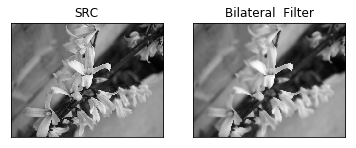

In [109]:
plt.subplot(121)
plt.imshow(gray,'gray')
plt.title('SRC')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(dst,'gray')
plt.title('Bilateral  Filter')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

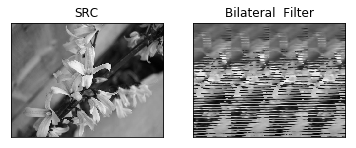

In [110]:
plt.subplot(121)
plt.imshow(gray,'gray')
plt.title('SRC')
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(dst_rgb[:,:,2],'gray')
plt.title('Bilateral  Filter')
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

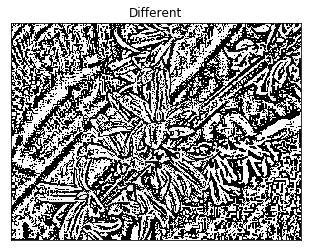

In [111]:
diff = dst - gray
diff[diff < 0] = 0
diff[diff > 255] = 255
plt.imshow(diff,'gray')
plt.title('Different')
plt.xticks([])
plt.yticks([])